# PBDL (Physics Based Deep learning)

### Differentiable Physics
Using domain Knowledge in form of model equations & then integrate discretized version of these model into training process.
<br>

$ f^* $ : Unknown function we wants to find.
<br>
$ f*: X \rightarrow Y $
<br>
$ P^*: Y \rightarrow Z $ is the generic differential equation.
<br>
$ \mathbf{P}^* $ is the time evolution.

<br>
To keep things simple we look at mapping back to input space $X$.
<br>
- Using classical approach $f$ can be trained by collecting data $(x,y)$ , $x \in X$ and $ y \in Y $.
- In contrast to this supervised approach DP(Differentiable physics) takes advantage of the fact that we can discretized version of physics model $P$ and employ it to guide the training of $f$.

**We want $f$ to be aware of our simulator $P$ and to interact with it.**
<br>
**Note :** In order for differentiable physics approach to work, $P$ has to be differentiable. These differentials in the form of the gradient are what's driving the learning process.

## Finding Inverse function of Parabola
<br>
Here we have, $P : y \rightarrow y^2 $ in the interval [0,1]. <br>
We have to find the unknown function $f$ such that $P(f(x)) = x $ for all $x \in [0,1]$

In [6]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

## Classical Machine learning approach
We can randomly choose positive and negative square roots as data for the supervised learning. 

In [7]:
# X-Data
N = 200
X = np.random.random(N)

In [8]:
# Generation Y-Data
sign = (- np.ones((N,)))**np.random.randint(2,size=N)
Y = np.sqrt(X) * sign

In [9]:
# Neural network
act = tf.keras.layers.ReLU()
nn_sv = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation=act, input_shape=(1,)),
  tf.keras.layers.Dense(10, activation=act),
  tf.keras.layers.Dense(1,activation='linear')])

In [13]:
# Loss function
loss_sv = tf.keras.losses.MeanSquaredError()
optimizer_sv = tf.keras.optimizers.Adam(learning_rate=0.001)
nn_sv.compile(optimizer=optimizer_sv, loss=loss_sv)

# Training
results_sv = nn_sv.fit(X, Y, epochs=10, batch_size= 5, verbose=1)

Epoch 1/10
40/40 [==============================] - 0s 440us/step - loss: 0.4904
Epoch 2/10
40/40 [==============================] - 0s 428us/step - loss: 0.4934
Epoch 3/10
40/40 [==============================] - 0s 407us/step - loss: 0.4905
Epoch 4/10
40/40 [==============================] - 0s 385us/step - loss: 0.4905
Epoch 5/10
40/40 [==============================] - 0s 380us/step - loss: 0.4912
Epoch 6/10
40/40 [==============================] - 0s 375us/step - loss: 0.4897
Epoch 7/10
40/40 [==============================] - 0s 380us/step - loss: 0.4898
Epoch 8/10
40/40 [==============================] - 0s 378us/step - loss: 0.4900
Epoch 9/10
40/40 [==============================] - 0s 366us/step - loss: 0.4895
Epoch 10/10
40/40 [==============================] - 0s 373us/step - loss: 0.4907


7/7 [==============================] - 0s 491us/step


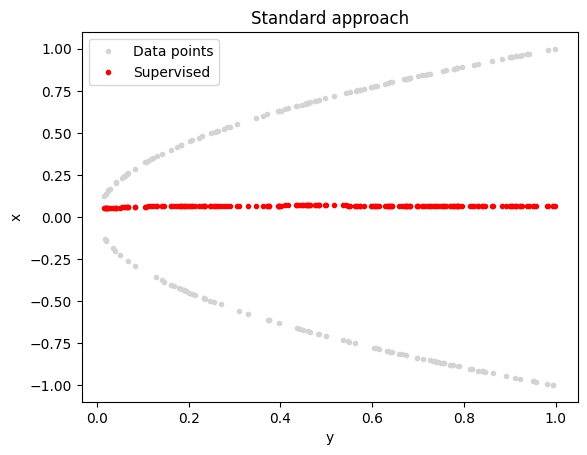

In [14]:
# Results
plt.plot(X,Y,'.',label='Data points', color="lightgray")
plt.plot(X,nn_sv.predict(X),'.',label='Supervised', color="red")
plt.xlabel('y')
plt.ylabel('x')
plt.title('Standard approach')
plt.legend()
plt.show()

This is not right. It appears like NN is taking average of the positive and negative square root. This is caused by relative coarse sampling. 

## Differentiable Physics Approach
This time we will include out discretized physics model $P$ in traning. <br>
We will keep the same architecture of the model.

In [15]:
# Model
nn_dp = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation=act, input_shape=(1,)),
  tf.keras.layers.Dense(10, activation=act),
  tf.keras.layers.Dense(1, activation='linear')])

Loss function is very import in Differentiable physics approach. `Loss_dp` computes the square of the prediction `y_pred`.
<br>
We can also evaluate finite-difference stencils on predictions. 

In [16]:
#Loss
mse = tf.keras.losses.MeanSquaredError()
def loss_dp(y_true, y_pred): 
    return mse(y_true,y_pred**2) # discretized model

optimizer_dp = tf.keras.optimizers.Adam(learning_rate=0.001)
nn_dp.compile(optimizer=optimizer_dp, loss=loss_dp)

In [23]:
#Training
results_dp = nn_dp.fit(X, X, epochs=10, batch_size=5, verbose=1)

Epoch 1/10
40/40 [==============================] - 0s 459us/step - loss: 0.0016
Epoch 2/10
40/40 [==============================] - 0s 440us/step - loss: 0.0017
Epoch 3/10
40/40 [==============================] - 0s 386us/step - loss: 0.0018
Epoch 4/10
40/40 [==============================] - 0s 377us/step - loss: 0.0017
Epoch 5/10
40/40 [==============================] - 0s 355us/step - loss: 0.0017
Epoch 6/10
40/40 [==============================] - 0s 377us/step - loss: 0.0017
Epoch 7/10
40/40 [==============================] - 0s 374us/step - loss: 0.0018
Epoch 8/10
40/40 [==============================] - 0s 361us/step - loss: 0.0017
Epoch 9/10
40/40 [==============================] - 0s 363us/step - loss: 0.0016
Epoch 10/10
40/40 [==============================] - 0s 351us/step - loss: 0.0018


7/7 [==============================] - 0s 638us/step


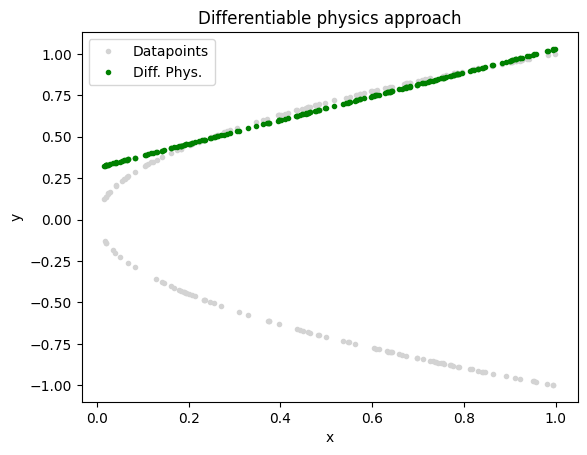

In [24]:
# Results
plt.plot(X,Y,'.',label='Datapoints', color="lightgray")
#plt.plot(X,nn_sv.predict(X),'.',label='Supervised', color="red") # optional for comparison
plt.plot(X,nn_dp.predict(X),'.',label='Diff. Phys.', color="green") 
plt.xlabel('x')
plt.ylabel('y')
plt.title('Differentiable physics approach')
plt.legend()
plt.show()

Atleast it is close. In the range of about 0-0.1 it does not looks good. Also we are getting only one side of the curve. What is the reason for this ?
- We are only getting one side of the curve because we are representing the solutions with a deterministic function. Top or bottom is determined randomly so if we retrain the model multiple time we can see that some of the models plot bottom curves while other plots top curve. 
- Why the output looks linear instead of a curve near zero ? This is beacause of the weak/small neural network.

<br>
Below I have made a bigger NN, and we can see the output is much closer to the actual plot.

Epoch 1/10
40/40 [==============================] - 0s 547us/step - loss: 0.1072
Epoch 2/10
40/40 [==============================] - 0s 520us/step - loss: 0.0033
Epoch 3/10
40/40 [==============================] - 0s 523us/step - loss: 0.0017
Epoch 4/10
40/40 [==============================] - 0s 563us/step - loss: 8.9471e-04
Epoch 5/10
40/40 [==============================] - 0s 766us/step - loss: 5.6747e-04
Epoch 6/10
40/40 [==============================] - 0s 564us/step - loss: 3.2071e-04
Epoch 7/10
40/40 [==============================] - 0s 537us/step - loss: 3.1711e-04
Epoch 8/10
40/40 [==============================] - 0s 569us/step - loss: 2.4603e-04
Epoch 9/10
40/40 [==============================] - 0s 566us/step - loss: 1.2163e-04
Epoch 10/10
7/7 [==============================] - 0s 459us/step


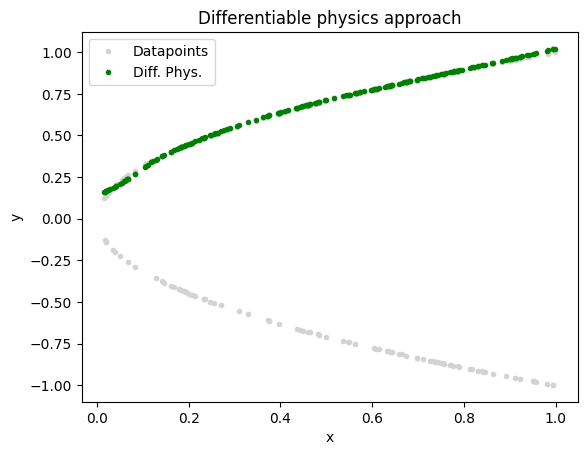

In [32]:
# Model
nn_dp_deep = tf.keras.models.Sequential([
  tf.keras.layers.Dense(20, activation=act, input_shape=(1,)),
  tf.keras.layers.Dense(40, activation=act),
  tf.keras.layers.Dense(100, activation=act),
  tf.keras.layers.Dense(40, activation=act),
  tf.keras.layers.Dense(1, activation='linear')])

#Loss
mse = tf.keras.losses.MeanSquaredError()
def loss_dp(y_true, y_pred): 
    return mse(y_true,y_pred**2) # discretized model

optimizer_dp = tf.keras.optimizers.Adam(learning_rate=0.001)
nn_dp_deep.compile(optimizer=optimizer_dp, loss=loss_dp)

#Training
results_dp = nn_dp_deep.fit(X, X, epochs=10, batch_size=5, verbose=1)

# Results
plt.plot(X,Y,'.',label='Datapoints', color="lightgray")
#plt.plot(X,nn_sv.predict(X),'.',label='Supervised', color="red") # optional for comparison
plt.plot(X,nn_dp_deep.predict(X),'.',label='Diff. Phys.', color="green") 
plt.xlabel('x')
plt.ylabel('y')
plt.title('Differentiable physics approach')
plt.legend()
plt.show()